In [2]:
from pde import NeuralNet, LinearQuadraticRegulator2D, GenerateData, NonLinear, CuckerSmale
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import ray
import copy
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

ModuleNotFoundError: No module named 'spdlayers'

In [159]:
@ray.remote
def experimentTrainingPhase(gammaData, gammaGradient, gammaResidual, interiorPointCount, dataPointCount, network_config, training_config):
    
    # network creation
    layers = network_config['layers']
    quadraticForm = network_config['quadraticForm']
    useAdditionalModel = network_config['useAdditionalModel']
    
    network = NeuralNet( 
        layers=layers, 
        quadraticForm=quadraticForm, 
        useAdditionalModel=useAdditionalModel
    )
    
    # pde creation
    gamma = {'data': gammaData, 'gradient': gammaGradient, 'residual': gammaResidual, 'matrix': 0}
    pde = NonLinear( network=network, gamma=gamma )

    
    lrs = training_config['lrs']
    iterations = training_config['iterations']

    resu = pde.train(
        interiorPointCount=interiorPointCount,
        dataPointCount=dataPointCount,
        lrs=lrs,
        iterations=iterations
    )

    info_dict = {}
    info_dict['pde'] = pde
    info_dict['mse'] = resu['mse']
    info_dict['loss'] = resu['loss']
    info_dict['config'] = {
        'gamma': gamma,
        'interiorPointCount': interiorPointCount,
        'dataPointCount': dataPointCount,
        'lrs': lrs,
        'iterations': iterations,
        'layers': layers,
        'quadraticForm': quadraticForm,
        'useAdditionalModel': useAdditionalModel
    }
    
    return info_dict

def launchClassicExperiment():
    # configure the network
    layers = [2, 20, 20, 20, 1]
    quadraticForm = False
    useAdditionalModel = False

    network_config = {
        'layers': layers,
        'quadraticForm': quadraticForm,
        'useAdditionalModel': useAdditionalModel
    }

    lrs = [1e-2, 1e-3]
    iterations = [1000, 2000]

    training_config = {
        'lrs': lrs,
        'iterations': iterations
    }

    dataPointCount = 20
    interiorPointCount = 50

    nexp = 10
    params = [[0, 0, 1, interiorPointCount, dataPointCount]] * nexp
    params += [[1, 0, 0, interiorPointCount, dataPointCount]] * nexp
    params += [[1, 1, 0, interiorPointCount, dataPointCount]] * nexp
    params += [[1, 1, 0.1, interiorPointCount, dataPointCount]] * nexp
    params += [[1, 1, 0.5, interiorPointCount, dataPointCount]] * nexp
    params += [[1, 1, 1., interiorPointCount, dataPointCount]] * nexp

    resu = []

    for gammaData, gammaGradient, gammaResidual, interiorPointCount, dataPointCount in params:
        resu_exp = experimentTrainingPhase.remote(
            gammaData=gammaData,
            gammaGradient=gammaGradient,
            gammaResidual=gammaResidual,
            interiorPointCount=interiorPointCount,
            dataPointCount=dataPointCount,
            network_config=network_config,
            training_config=training_config
        )
        resu.append(resu_exp)

    resu = ray.get(resu)
    resu = pd.DataFrame(resu)
    resu.to_pickle("feb_experiments_non_linear_2d.csv")


In [165]:
ray.shutdown()
ray.init(num_cpus=6)

2022-02-12 16:05:32,615	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '192.168.0.10',
 'raylet_ip_address': '192.168.0.10',
 'redis_address': '192.168.0.10:49349',
 'object_store_address': '/tmp/ray/session_2022-02-12_16-05-30_911970_92572/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-02-12_16-05-30_911970_92572/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2022-02-12_16-05-30_911970_92572',
 'metrics_export_port': 60734,
 'node_id': '27fed4af58850a7dfdeaa3cbe71e37d8a266ed65e4cf121544a4adf4'}

In [166]:
launchClassicExperiment()

(pid=94298) xInt:  torch.Size([50, 2])
(pid=94298) xData:  torch.Size([20, 2])
(pid=94298) 0 / 3000 (0 / 1000), lr:1.0e-02, loss:1.32e-01 (data: 0.00e+00, grad: 0.00e+00, res: 1.32e-01, mat: 0.00e+00)
(pid=94298) 10 / 3000 (10 / 1000), lr:1.0e-02, loss:1.89e-01 (data: 0.00e+00, grad: 0.00e+00, res: 1.89e-01, mat: 0.00e+00)
(pid=94298) 20 / 3000 (20 / 1000), lr:1.0e-02, loss:1.68e-01 (data: 0.00e+00, grad: 0.00e+00, res: 1.68e-01, mat: 0.00e+00)
(pid=94298) 30 / 3000 (30 / 1000), lr:1.0e-02, loss:1.43e-01 (data: 0.00e+00, grad: 0.00e+00, res: 1.43e-01, mat: 0.00e+00)
(pid=94298) 40 / 3000 (40 / 1000), lr:1.0e-02, loss:1.31e-01 (data: 0.00e+00, grad: 0.00e+00, res: 1.31e-01, mat: 0.00e+00)
(pid=94303) xInt:  torch.Size([50, 2])
(pid=94303) xData:  torch.Size([20, 2])
(pid=94303) 0 / 3000 (0 / 1000), lr:1.0e-02, loss:1.92e-01 (data: 0.00e+00, grad: 0.00e+00, res: 1.92e-01, mat: 0.00e+00)
(pid=94303) 10 / 3000 (10 / 1000), lr:1.0e-02, loss:2.08e-01 (data: 0.00e+00, grad: 0.00e+00, res: 2.0

In [167]:
df = pd.read_pickle('feb_experiments_non_linear_2d.csv')

In [168]:
def computeTypes(config):
    if config['gamma']['residual'] != 0:
        if config['gamma']['data'] != 0:
            return 'data_gradient_residual_%.2f'%config['gamma']['residual']
        else:
            return 'residual'
    else:
        if config['gamma']['gradient'] != 0:
            return 'data_gradient'
        else:
            return 'data'

df['type'] = df['config'].apply(computeTypes)
resu = df.groupby('type')['mse'].apply(lambda x: np.median( np.vstack( x.to_numpy() ), axis=0 ) ).to_frame(name='mse_median')

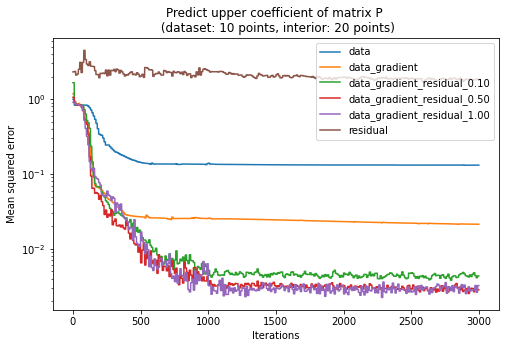

In [169]:
fig, ax = plt.subplots(figsize=(8, 5))
for idx, row in resu.iterrows():
    ax.plot(row['mse_median'], label=idx)
ax.set_yscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel('Mean squared error')
ax.legend(loc='upper right')
ax.set_title('Predict upper coefficient of matrix P \n (dataset: 10 points, interior: 20 points)' );

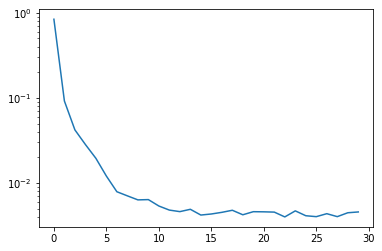

In [170]:
plt.plot( resu.iloc[2, 0][50::100] )
plt.yscale('log')

In [171]:
from scipy import interpolate

In [172]:
f0 = interpolate.interp1d(x=np.arange(3000), y=resu.iloc[0, 0], bounds_error=False, fill_value='extrapolate')
f1 = interpolate.interp1d(x=np.arange(3000), y=resu.iloc[1, 0], bounds_error=False, fill_value='extrapolate')
f2 = interpolate.interp1d(x=np.arange(3000), y=resu.iloc[2, 0], bounds_error=False, fill_value='extrapolate')
f3 = interpolate.interp1d(x=np.arange(3000), y=resu.iloc[5, 0], bounds_error=False, fill_value='extrapolate')

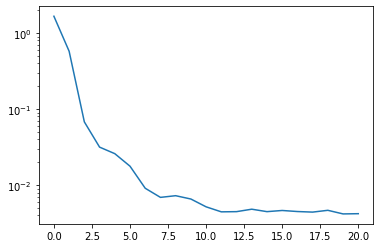

In [173]:
plt.plot( f2(np.linspace(0, 1990, 21)) )
plt.yscale('log')

In [174]:
np.savetxt( 'feb_exp_non_linear_all_methods.csv',
    np.vstack( [
        np.linspace(0, 2000, 21),
        f0(np.linspace(0, 1990, 21)),
        f1(np.linspace(0, 1990, 21)),
        f2(np.linspace(0, 1990, 21)),
        f3(np.linspace(0, 1990, 21))
        ] ).T,
    delimiter=',',
    fmt='%.8f' )

In [71]:
resu.iloc[2, 0][::90].shape

(34,)

# 2 step learning linear

In [106]:
@ray.remote
def experimentTwoStepsLearning(interiorPointCount, dataPointCount, network_config, training_config):
    
    # network creation
    layers = network_config['layers']
    quadraticForm = network_config['quadraticForm']
    useAdditionalModel = network_config['useAdditionalModel']
    
    network = NeuralNet( 
        layers=layers, 
        quadraticForm=quadraticForm, 
        useAdditionalModel=useAdditionalModel
    )

    # pde creation
    gamma_data = {'data': 1., 'gradient': 1., 'residual': 0., 'matrix':0}
    pde = LinearQuadraticRegulator2D( network=network, gamma=gamma_data )

    lrs_data = training_config['lrs_data']
    iterations_data = training_config['iterations_data']

    resu_data = pde.train(
        interiorPointCount=interiorPointCount,
        dataPointCount=dataPointCount,
        lrs=lrs_data,
        iterations=iterations_data
    )

    saved_weights = copy.deepcopy( pde.network.state_dict() )

    # second training
    gamma_residual = {'data': 0., 'gradient': 0., 'residual': 1., 'matrix':0}
    pde = LinearQuadraticRegulator2D( network=network, gamma=gamma_residual, correctShift=True )

    pde.network.load_state_dict( saved_weights )

    lrs_residual = training_config['lrs_residual']
    iterations_residual = training_config['iterations_residual']

    resu_residual = pde.train(
        interiorPointCount=interiorPointCount,
        dataPointCount=dataPointCount,
        lrs=lrs_residual,
        iterations=iterations_residual
    )

    info_dict = {}
    info_dict['pde'] = pde
    info_dict['mse_data'] = resu_data['mse']
    info_dict['mse_residual'] = resu_residual['mse']
    info_dict['loss_data'] = resu_data['loss']
    info_dict['loss_residual'] = resu_residual['loss']
    info_dict['config'] = {
        'gamma_data': gamma_data,
        'gamma_residual': gamma_residual,
        'interiorPointCount': interiorPointCount,
        'dataPointCount': dataPointCount,
        'lrs_data': lrs_data,
        'lrs_residual': lrs_residual,
        'iterations_data': iterations_data,
        'iterations_residual': iterations_residual,
        'layers': layers,
        'quadraticForm': quadraticForm,
        'useAdditionalModel': useAdditionalModel
    }
    
    return info_dict

def launchTwoStepsLearningExperiment():
    # configure the network
    layers = [2, 20, 20, 20, 1]
    quadraticForm = False
    useAdditionalModel = False

    network_config = {
        'layers': layers,
        'quadraticForm': quadraticForm,
        'useAdditionalModel': useAdditionalModel
    }

    # configure the training for data and residual
    lrs_data = [1e-2, 1e-3]
    iterations_data = [1000, 2000]
    lrs_residual = [1e-2, 1e-3, 1e-4]
    iterations_residual = [2000, 4000, 8000]

    training_config = {
        'lrs_data': lrs_data,
        'iterations_data': iterations_data,
        'lrs_residual': lrs_residual,
        'iterations_residual': iterations_residual,
    }

    resu = []

    dataPointCount = 20
    interiorPointCount = 100

    params = [[interiorPointCount, 1]] * 10
    params += [[interiorPointCount, 5]] * 10
    params += [[interiorPointCount, 10]] * 10
    params += [[interiorPointCount, 20]] * 10
    params += [[interiorPointCount, 50]] * 10
    params += [[interiorPointCount, 100]] * 10

    for interiorPointCount, dataPointCount in params:
        resu_exp = experimentTwoStepsLearning.remote(
            interiorPointCount=interiorPointCount,
            dataPointCount=dataPointCount,
            network_config=network_config,
            training_config=training_config,
        )
        resu.append(resu_exp)

    resu = ray.get(resu)
    resu = pd.DataFrame(resu)
    resu.to_pickle("feb_exp_linear.csv")

In [107]:
ray.shutdown()
ray.init(num_cpus=6)

2022-02-02 18:53:18,762	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.0.10',
 'raylet_ip_address': '192.168.0.10',
 'redis_address': '192.168.0.10:6379',
 'object_store_address': '/tmp/ray/session_2022-02-02_18-53-17_285391_35508/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-02-02_18-53-17_285391_35508/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2022-02-02_18-53-17_285391_35508',
 'metrics_export_port': 65525,
 'node_id': 'fba2d045302b11a4910a513a3a68dfa90c68844cf8f5821cf903ef7b'}

In [108]:
launchTwoStepsLearningExperiment()

(pid=36854) xInt:  torch.Size([100, 2])
(pid=36854) xData:  torch.Size([1, 2])
(pid=36854) 0 / 3000 (0 / 1000), lr:1.0e-02, loss:8.42e-01 (data: 8.38e-01, grad: 3.86e-03, res: 0.00e+00, mat: 0.00e+00)
(pid=36853) xInt:  torch.Size([100, 2])
(pid=36853) xData:  torch.Size([1, 2])
(pid=36853) 0 / 3000 (0 / 1000), lr:1.0e-02, loss:2.13e-01 (data: 5.75e-02, grad: 1.55e-01, res: 0.00e+00, mat: 0.00e+00)
(pid=36852) xInt:  torch.Size([100, 2])
(pid=36852) xData:  torch.Size([1, 2])
(pid=36852) 0 / 3000 (0 / 1000), lr:1.0e-02, loss:9.35e-02 (data: 2.46e-02, grad: 6.89e-02, res: 0.00e+00, mat: 0.00e+00)
(pid=36856) xInt:  torch.Size([100, 2])
(pid=36856) xData:  torch.Size([1, 2])
(pid=36856) 0 / 3000 (0 / 1000), lr:1.0e-02, loss:7.51e-01 (data: 5.61e-01, grad: 1.90e-01, res: 0.00e+00, mat: 0.00e+00)
(pid=36855) xInt:  torch.Size([100, 2])
(pid=36855) xData:  torch.Size([1, 2])
(pid=36855) 0 / 3000 (0 / 1000), lr:1.0e-02, loss:1.32e+00 (data: 1.15e+00, grad: 1.72e-01, res: 0.00e+00, mat: 0.00e

## 2d linear: influence of number of datapoint 
-> this is important to get the right solution + reduce the number of point

In [101]:
df = pd.read_pickle('experiments/feb/feb_exp_linear.csv')

In [102]:
df['dataPointCount'] = df['config'].apply(lambda x: x['dataPointCount'])

In [103]:
mse_data = df.groupby('dataPointCount').apply( lambda df: np.median( np.vstack( df['mse_data'].to_numpy()), axis=0 ))
mse_residual = df.groupby('dataPointCount').apply( lambda df: np.median( np.vstack( df['mse_residual'].to_numpy()), axis=0 ))

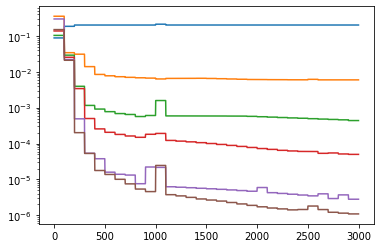

In [104]:
fig, ax = plt.subplots()
for i in range(6):
    ax.plot( mse_data.iloc[i] )
ax.set_yscale('log')

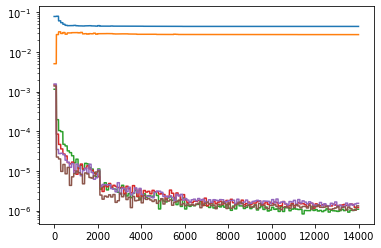

In [105]:
fig, ax = plt.subplots()
for i in range(6):
    ax.plot( mse_residual.iloc[i] )
ax.set_yscale('log')

In [106]:
resu_linear = pd.DataFrame([])
resu_linear['mse_data'] = mse_data.apply(lambda x: x[-1])
resu_linear['mse_residual'] = mse_residual.apply(lambda x: x[-1])

In [107]:
resu_linear = resu_linear.reset_index()

In [108]:
np.savetxt( 'feb_exp_linear_results.csv',
    np.vstack( [
        resu_linear.index.tolist(),
        resu_linear['dataPointCount'],
        resu_linear['mse_data'],
        resu_linear['mse_residual']
        ] ).T,
    delimiter=',',
    fmt='%.8f' )

## 2D non linear case
-> the SDRE is not enought to give a good solution

dataset only with 10, 20, 50, 100 and then 2 steps learning with only 20 points

In [38]:
network = NeuralNet( 
    layers=[2, 20, 20, 20, 1], 
    quadraticForm=False, 
    useAdditionalModel=False
)

# pde creation
gamma_data = {'data': 1., 'gradient': 1., 'residual': 0., 'matrix':0}
pde = NonLinear( network=network, gamma=gamma_data )

lrs_data = [1e-2, 1e-3]
iterations_data = [1000, 2000]

resu_data = pde.train(
    interiorPointCount=100,
    dataPointCount=20,
    lrs=lrs_data,
    iterations=iterations_data
)

xInt:  torch.Size([100, 2])
xData:  torch.Size([20, 2])
0 / 3000 (0 / 1000), lr:1.0e-02, loss:3.47e+00 (data: 1.21e+00, grad: 2.26e+00, res: 0.00e+00, mat: 0.00e+00)
100 / 3000 (100 / 1000), lr:1.0e-02, loss:5.39e-01 (data: 2.59e-02, grad: 5.13e-01, res: 0.00e+00, mat: 0.00e+00)
200 / 3000 (200 / 1000), lr:1.0e-02, loss:1.31e-01 (data: 1.48e-02, grad: 1.16e-01, res: 0.00e+00, mat: 0.00e+00)
300 / 3000 (300 / 1000), lr:1.0e-02, loss:9.49e-03 (data: 1.09e-03, grad: 8.40e-03, res: 0.00e+00, mat: 0.00e+00)
400 / 3000 (400 / 1000), lr:1.0e-02, loss:4.80e-03 (data: 4.96e-04, grad: 4.31e-03, res: 0.00e+00, mat: 0.00e+00)
500 / 3000 (500 / 1000), lr:1.0e-02, loss:3.69e-03 (data: 4.40e-04, grad: 3.25e-03, res: 0.00e+00, mat: 0.00e+00)
600 / 3000 (600 / 1000), lr:1.0e-02, loss:2.87e-03 (data: 3.87e-04, grad: 2.48e-03, res: 0.00e+00, mat: 0.00e+00)
700 / 3000 (700 / 1000), lr:1.0e-02, loss:2.17e-03 (data: 3.33e-04, grad: 1.84e-03, res: 0.00e+00, mat: 0.00e+00)
800 / 3000 (800 / 1000), lr:1.0e-02,

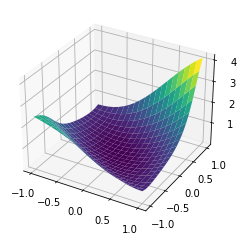

In [39]:
x = np.linspace(-1, 1, 20)
y = np.linspace(-1, 1, 20)
X, Y = np.meshgrid(x, y)

Z = pde.network.computeValueFunction( torch.tensor( [X.reshape(-1, 1), Y.reshape(-1, 1)] ).squeeze().float().T ).reshape(-1, 20).detach().numpy().T

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis');

In [40]:
Zdata = Z.copy()

In [42]:
data_coordinates = resu_data.loc[0, 'xData']

In [163]:
saved_weights = copy.deepcopy( pde.network.state_dict() )

# second training
gamma_residual = {'data': 0., 'gradient': 0., 'residual': 1., 'matrix':0}
pde = NonLinear( network=network, gamma=gamma_residual, correctShift=True )

pde.network.load_state_dict( saved_weights )

lrs_residual = [1e-2, 1e-3, 1e-4]
iterations_residual = [2000, 4000, 8000]

resu_residual = pde.train(
    interiorPointCount=100,
    dataPointCount=1,
    lrs=lrs_residual,
    iterations=iterations_residual
)

xInt:  torch.Size([100, 2])
xData:  torch.Size([1, 2])
0 / 14000 (0 / 2000), lr:1.0e-02, loss:2.57e-04 (data: 0.00e+00, grad: 0.00e+00, res: 2.57e-04, mat: 0.00e+00)
100 / 14000 (100 / 2000), lr:1.0e-02, loss:6.29e-04 (data: 0.00e+00, grad: 0.00e+00, res: 6.29e-04, mat: 0.00e+00)
200 / 14000 (200 / 2000), lr:1.0e-02, loss:2.75e-04 (data: 0.00e+00, grad: 0.00e+00, res: 2.75e-04, mat: 0.00e+00)
300 / 14000 (300 / 2000), lr:1.0e-02, loss:5.63e-04 (data: 0.00e+00, grad: 0.00e+00, res: 5.63e-04, mat: 0.00e+00)
400 / 14000 (400 / 2000), lr:1.0e-02, loss:2.85e-04 (data: 0.00e+00, grad: 0.00e+00, res: 2.85e-04, mat: 0.00e+00)
500 / 14000 (500 / 2000), lr:1.0e-02, loss:3.42e-02 (data: 0.00e+00, grad: 0.00e+00, res: 3.42e-02, mat: 0.00e+00)
600 / 14000 (600 / 2000), lr:1.0e-02, loss:2.84e-04 (data: 0.00e+00, grad: 0.00e+00, res: 2.84e-04, mat: 0.00e+00)
700 / 14000 (700 / 2000), lr:1.0e-02, loss:1.04e-03 (data: 0.00e+00, grad: 0.00e+00, res: 1.04e-03, mat: 0.00e+00)
800 / 14000 (800 / 2000), lr:

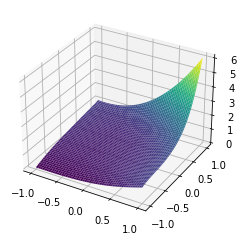

In [164]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

Z = pde.network.computeValueFunction( torch.tensor( [X.reshape(-1, 1), Y.reshape(-1, 1)] ).squeeze().float().T ).reshape(-1, 100).detach().numpy().T
Z -= Z.min()

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis');

In [90]:
@ray.remote
def experimentTwoStepsLearning(interiorPointCount, dataPointCount, network_config, training_config):
    
    # network creation
    layers = network_config['layers']
    quadraticForm = network_config['quadraticForm']
    useAdditionalModel = network_config['useAdditionalModel']
    
    network = NeuralNet( 
        layers=layers, 
        quadraticForm=quadraticForm, 
        useAdditionalModel=useAdditionalModel
    )

    # pde creation
    gamma_data = {'data': 1., 'gradient': 1., 'residual': 0., 'matrix':0}
    pde = NonLinear( network=network, gamma=gamma_data )

    lrs_data = training_config['lrs_data']
    iterations_data = training_config['iterations_data']

    resu_data = pde.train(
        interiorPointCount=interiorPointCount,
        dataPointCount=dataPointCount,
        lrs=lrs_data,
        iterations=iterations_data
    )

    saved_weights = copy.deepcopy( pde.network.state_dict() )

    # second training
    gamma_residual = {'data': 0., 'gradient': 0., 'residual': 1., 'matrix':0}
    pde = NonLinear( network=network, gamma=gamma_residual, correctShift=True )

    pde.network.load_state_dict( saved_weights )

    lrs_residual = training_config['lrs_residual']
    iterations_residual = training_config['iterations_residual']

    resu_residual = pde.train(
        interiorPointCount=interiorPointCount,
        dataPointCount=dataPointCount,
        lrs=lrs_residual,
        iterations=iterations_residual
    )

    info_dict = {}
    info_dict['pde'] = pde
    info_dict['mse_data'] = resu_data['mse']
    info_dict['mse_residual'] = resu_residual['mse']
    info_dict['loss_data'] = resu_data['loss']
    info_dict['loss_residual'] = resu_residual['loss']
    info_dict['config'] = {
        'gamma_data': gamma_data,
        'gamma_residual': gamma_residual,
        'interiorPointCount': interiorPointCount,
        'dataPointCount': dataPointCount,
        'lrs_data': lrs_data,
        'lrs_residual': lrs_residual,
        'iterations_data': iterations_data,
        'iterations_residual': iterations_residual,
        'layers': layers,
        'quadraticForm': quadraticForm,
        'useAdditionalModel': useAdditionalModel
    }
    
    return info_dict

def launchTwoStepsLearningExperiment():
    # configure the network
    layers = [2, 20, 20, 20, 1]
    quadraticForm = False
    useAdditionalModel = False

    network_config = {
        'layers': layers,
        'quadraticForm': quadraticForm,
        'useAdditionalModel': useAdditionalModel
    }

    # configure the training for data and residual
    lrs_data = [1e-2, 1e-3]
    iterations_data = [1000, 2000]
    lrs_residual = [1e-2, 1e-3, 1e-4]
    iterations_residual = [2000, 4000, 8000]

    training_config = {
        'lrs_data': lrs_data,
        'iterations_data': iterations_data,
        'lrs_residual': lrs_residual,
        'iterations_residual': iterations_residual,
    }

    resu = []

    dataPointCount = 20
    interiorPointCount = 100

    params = [[interiorPointCount, 1]] * 10
    params += [[interiorPointCount, 5]] * 10
    params += [[interiorPointCount, 10]] * 10
    params += [[interiorPointCount, 20]] * 10
    params += [[interiorPointCount, 50]] * 10
    params += [[interiorPointCount, 100]] * 10

    for interiorPointCount, dataPointCount in params:
        resu_exp = experimentTwoStepsLearning.remote(
            interiorPointCount=interiorPointCount,
            dataPointCount=dataPointCount,
            network_config=network_config,
            training_config=training_config,
        )
        resu.append(resu_exp)

    resu = ray.get(resu)
    resu = pd.DataFrame(resu)
    resu.to_pickle("feb_exp_non_linear.csv")

In [89]:
ray.shutdown()
ray.init(num_cpus=6)

2022-02-02 18:42:31,861	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.0.10',
 'raylet_ip_address': '192.168.0.10',
 'redis_address': '192.168.0.10:6379',
 'object_store_address': '/tmp/ray/session_2022-02-02_18-42-30_481582_35508/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-02-02_18-42-30_481582_35508/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2022-02-02_18-42-30_481582_35508',
 'metrics_export_port': 65458,
 'node_id': 'db16db2ee6569b9a7a7b9c915de2009c2618082a1afbd93156b5c175'}

In [91]:
launchTwoStepsLearningExperiment()

(pid=36689) xInt:  torch.Size([100, 2])
(pid=36689) xData:  torch.Size([1, 2])
(pid=36689) 0 / 3000 (0 / 1000), lr:1.0e-02, loss:6.02e-01 (data: 3.67e-02, grad: 5.65e-01, res: 0.00e+00, mat: 0.00e+00)
(pid=36686) xInt:  torch.Size([100, 2])
(pid=36686) xData:  torch.Size([1, 2])
(pid=36686) 0 / 3000 (0 / 1000), lr:1.0e-02, loss:1.98e+00 (data: 1.81e+00, grad: 1.68e-01, res: 0.00e+00, mat: 0.00e+00)
(pid=36685) xInt:  torch.Size([100, 2])
(pid=36685) xData:  torch.Size([1, 2])
(pid=36685) 0 / 3000 (0 / 1000), lr:1.0e-02, loss:9.35e-01 (data: 1.44e-01, grad: 7.91e-01, res: 0.00e+00, mat: 0.00e+00)
(pid=36688) xInt:  torch.Size([100, 2])
(pid=36688) xData:  torch.Size([1, 2])
(pid=36688) 0 / 3000 (0 / 1000), lr:1.0e-02, loss:2.00e+01 (data: 1.15e+00, grad: 1.88e+01, res: 0.00e+00, mat: 0.00e+00)
(pid=36687) xInt:  torch.Size([100, 2])
(pid=36687) xData:  torch.Size([1, 2])
(pid=36687) 0 / 3000 (0 / 1000), lr:1.0e-02, loss:2.73e+00 (data: 5.82e-01, grad: 2.15e+00, res: 0.00e+00, mat: 0.00e

In [175]:
df = pd.read_pickle('experiments/feb/feb_exp_non_linear.csv')

In [176]:
df['dataPointCount'] = df['config'].apply(lambda x: x['dataPointCount'])

In [177]:
mse_data = df.groupby('dataPointCount').apply( lambda df: np.median( np.vstack( df['mse_data'].to_numpy()), axis=0 ))
mse_residual = df.groupby('dataPointCount').apply( lambda df: np.median( np.vstack( df['mse_residual'].to_numpy()), axis=0 ))

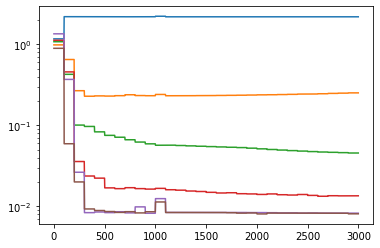

In [178]:
fig, ax = plt.subplots()
for i in range(6):
    ax.plot( mse_data.iloc[i] )
ax.set_yscale('log')

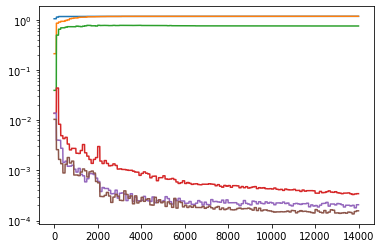

In [179]:
fig, ax = plt.subplots()
for i in range(6):
    ax.plot( mse_residual.iloc[i] )
ax.set_yscale('log')

In [154]:
resu_non_linear = pd.DataFrame([])
resu_non_linear['mse_data'] = mse_data.apply(lambda x: x[-1])
resu_non_linear['mse_residual'] = mse_residual.apply(lambda x: x[-1])

In [155]:
resu_non_linear = resu_non_linear.reset_index()
resu_non_linear

dataPointCount  mse_data  mse_residual
0               1  2.181217      1.176169
1               5  0.251505      1.179283
2              10  0.045610      0.754814
3              20  0.013527      0.000343
4              50  0.008260      0.000206
5             100  0.008112      0.000156

In [156]:
np.savetxt( 'feb_exp_non_linear_results.csv',
    np.vstack( [
        resu_non_linear.index.tolist(),
        resu_non_linear['dataPointCount'],
        resu_non_linear['mse_data'],
        resu_non_linear['mse_residual']
        ] ).T,
    delimiter=',',
    fmt='%.6f' )

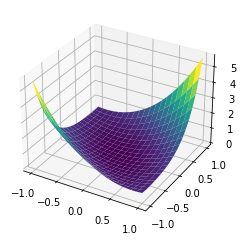

In [180]:
x = np.linspace(-1, 1, 20)
y = np.linspace(-1, 1, 20)
X, Y = np.meshgrid(x, y)

Z = df.loc[35, 'pde'].network.computeValueFunction( torch.tensor( [X.reshape(-1, 1), Y.reshape(-1, 1)] ).squeeze().float().T ).reshape(-1, 20).detach().numpy().T
Z -= Z.min()

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis');

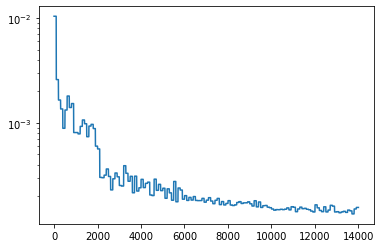

In [287]:
plt.plot( df.groupby('dataPointCount').apply( lambda df: np.median( np.vstack( df['mse_residual'].to_numpy()), axis=0 )).iloc[-1] )
plt.yscale('log')

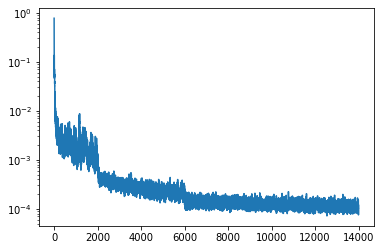

In [288]:
plt.plot( df.groupby('dataPointCount').apply( lambda df: np.median( np.vstack( df['loss_residual'].to_numpy()), axis=0 )).iloc[-1] )
plt.yscale('log')

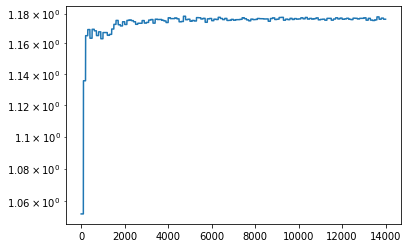

In [289]:
plt.plot( df.groupby('dataPointCount').apply( lambda df: np.median( np.vstack( df['mse_residual'].to_numpy()), axis=0 )).iloc[0] )
plt.yscale('log')

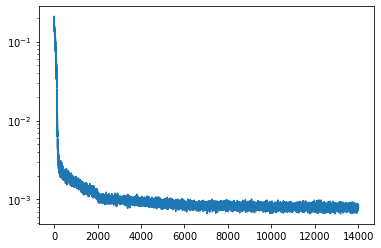

In [290]:
plt.plot( df.groupby('dataPointCount').apply( lambda df: np.median( np.vstack( df['loss_residual'].to_numpy()), axis=0 )).iloc[0] )
plt.yscale('log')

In [292]:
y = df.groupby('dataPointCount').apply( lambda df: np.median( np.vstack( df['loss_residual'].to_numpy()), axis=0 )).iloc[0]
f0 = interpolate.interp1d(x=np.arange(6000), y=y[:6000], bounds_error=False, fill_value='extrapolate')

y = df.groupby('dataPointCount').apply( lambda df: np.median( np.vstack( df['mse_residual'].to_numpy()), axis=0 )).iloc[0]
f1 = interpolate.interp1d(x=np.arange(6000), y=y[:6000], bounds_error=False, fill_value='extrapolate')

y = df.groupby('dataPointCount').apply( lambda df: np.median( np.vstack( df['loss_residual'].to_numpy()), axis=0 )).iloc[-1]
f2 = interpolate.interp1d(x=np.arange(6000), y=y[:6000], bounds_error=False, fill_value='extrapolate')

y = df.groupby('dataPointCount').apply( lambda df: np.median( np.vstack( df['mse_residual'].to_numpy()), axis=0 )).iloc[-1]
f3 = interpolate.interp1d(x=np.arange(6000), y=y[:6000], bounds_error=False, fill_value='extrapolate')

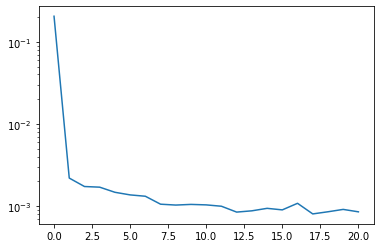

In [298]:
plt.plot( f0(np.linspace(0, 5990, 21)) )
plt.yscale('log')

In [299]:
np.savetxt( 'feb_exp_non_linear_residual_solutions.csv',
    np.vstack( [
        np.linspace(0, 6000, 21),
        f0(np.linspace(0, 5990, 21)),
        f1(np.linspace(0, 5990, 21)),
        f2(np.linspace(0, 5990, 21)),
        f3(np.linspace(0, 5990, 21))
        ] ).T,
    delimiter=',',
    fmt='%.8f' )

In [158]:
Zresidual = Z.copy()

In [159]:
network = NeuralNet( 
    layers=[2, 20, 20, 20, 1], 
    quadraticForm=False, 
    useAdditionalModel=False
)

# pde creation
gamma_data = {'data': 1., 'gradient': 1., 'residual': 0., 'matrix':0}
pde = NonLinear( network=network, gamma=gamma_data )

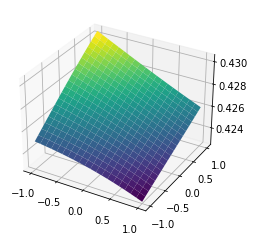

In [160]:
x = np.linspace(-1, 1, 20)
y = np.linspace(-1, 1, 20)
X, Y = np.meshgrid(x, y)

Z = pde.network.computeValueFunction( torch.tensor( [X.reshape(-1, 1), Y.reshape(-1, 1)] ).squeeze().float().T ).reshape(-1, 20).detach().numpy().T

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis');

In [161]:
Zini = Z.copy()

In [162]:
ztrue = pde.groundTruthSolution(x).reshape(-1, 100).numpy()

In [163]:
from scipy import interpolate
xnode = np.linspace(-1, 1, 100)
x, y = np.meshgrid(xnode, xnode)
interpol_ztrue = interpolate.interp2d(x, y, ztrue)

In [164]:
total_v = np.zeros((20, 20))
for i, x1 in enumerate( np.linspace(-1, 1, 20) ):
    for j, x2 in enumerate( np.linspace(-1, 1, 20) ):
        total_v[i, j] = interpol_ztrue( x1, x2 )

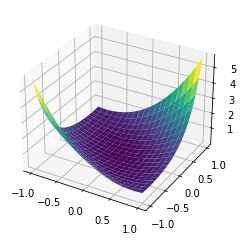

In [165]:
x = np.linspace(-1, 1, 20)
y = np.linspace(-1, 1, 20)
X, Y = np.meshgrid(x, y)

Z = pde.groundTruthSolution(x).reshape(-1, 100)[::5, ::5].numpy()

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, total_v.T, cmap='viridis');

In [166]:
Ztrue = total_v.T.copy()

In [173]:
# residual only - example of a solution that is invalid
network = NeuralNet( 
    layers=[2, 20, 20, 20, 1], 
    quadraticForm=False, 
    useAdditionalModel=False
)

gamma_residual = {'data': 0., 'gradient': 0., 'residual': 1., 'matrix':0}
pde = NonLinear( network=network, gamma=gamma_residual, correctShift=True )

lrs_residual = [1e-2, 1e-3, 1e-4]
iterations_residual = [2000, 4000, 8000]

In [174]:
resu_residual = pde.train(
    interiorPointCount=100,
    dataPointCount=1,
    lrs=lrs_residual,
    iterations=iterations_residual
)

xInt:  torch.Size([100, 2])
xData:  torch.Size([1, 2])
0 / 14000 (0 / 2000), lr:1.0e-02, loss:1.44e-01 (data: 0.00e+00, grad: 0.00e+00, res: 1.44e-01, mat: 0.00e+00)
100 / 14000 (100 / 2000), lr:1.0e-02, loss:2.04e-03 (data: 0.00e+00, grad: 0.00e+00, res: 2.04e-03, mat: 0.00e+00)
200 / 14000 (200 / 2000), lr:1.0e-02, loss:2.71e-03 (data: 0.00e+00, grad: 0.00e+00, res: 2.71e-03, mat: 0.00e+00)
300 / 14000 (300 / 2000), lr:1.0e-02, loss:1.93e-03 (data: 0.00e+00, grad: 0.00e+00, res: 1.93e-03, mat: 0.00e+00)
400 / 14000 (400 / 2000), lr:1.0e-02, loss:3.18e-03 (data: 0.00e+00, grad: 0.00e+00, res: 3.18e-03, mat: 0.00e+00)
500 / 14000 (500 / 2000), lr:1.0e-02, loss:2.16e-03 (data: 0.00e+00, grad: 0.00e+00, res: 2.16e-03, mat: 0.00e+00)
600 / 14000 (600 / 2000), lr:1.0e-02, loss:3.00e-03 (data: 0.00e+00, grad: 0.00e+00, res: 3.00e-03, mat: 0.00e+00)
700 / 14000 (700 / 2000), lr:1.0e-02, loss:1.75e-03 (data: 0.00e+00, grad: 0.00e+00, res: 1.75e-03, mat: 0.00e+00)
800 / 14000 (800 / 2000), lr:

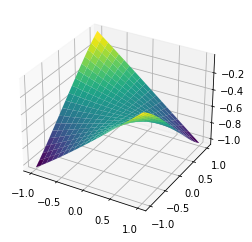

In [176]:
x = np.linspace(-1, 1, 20)
y = np.linspace(-1, 1, 20)
X, Y = np.meshgrid(x, y)

Z = pde.network.computeValueFunction( torch.tensor( [X.reshape(-1, 1), Y.reshape(-1, 1)] ).squeeze().float().T ).reshape(-1, 20).detach().numpy().T
#Z -= Z.min()

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis');

In [170]:
Zinvalid = Z.copy()

In [171]:
np.savetxt( 'feb_exp_non_linear_graph.csv',
    np.hstack( [
        X.reshape(-1, 1),
        Y.reshape(-1, 1),
        Zini.reshape(-1, 1),
        Zdata.reshape(-1, 1),
        Zresidual.reshape(-1, 1),
        Zinvalid.reshape(-1, 1),
        Ztrue.reshape(-1, 1)
        ] ),
    delimiter=',',
    fmt='%.6f' )

In [72]:
np.savetxt( 'feb_exp_non_linear_graph_data_coordinates.csv',
    torch.hstack( [data_coordinates, pde.dataValueFunction(data_coordinates)] ).detach(),
    delimiter=',',
    fmt='%.6f' )